In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as data
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Dense, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
start = '2005-01-01'
end = '2022-03-18'

df = data.DataReader('AAPL.US', 'stooq', start, end)
#df.to_csv('GameStop.csv')

In [3]:
df.tail() # 2005-01-07 시작

,Open,High,Low,Close,Volume
Date,,,,,
2005-01-07,0.9958,1.0658,0.9916,1.0601,2607118863
2005-01-06,0.9921,0.9935,0.9693,0.9881,822930454
2005-01-05,0.9788,0.9988,0.9788,0.9875,793814983
2005-01-04,0.9760,1.0023,0.9640,0.9788,1280464965
2005-01-03,0.9930,0.9967,0.9585,0.9687,808348758


In [4]:
df.reset_index(inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4333 non-null   datetime64[ns]
 1   Open    4333 non-null   float64       
 2   High    4333 non-null   float64       
 3   Low     4333 non-null   float64       
 4   Close   4333 non-null   float64       
 5   Volume  4333 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 203.2 KB


In [6]:
df['weekday'] = df['Date'].dt.weekday

In [7]:
df.tail()

,Date,Open,High,Low,Close,Volume,weekday
4328,2005-01-07,0.9958,1.0658,0.9916,1.0601,2607118863,4
4329,2005-01-06,0.9921,0.9935,0.9693,0.9881,822930454,3
4330,2005-01-05,0.9788,0.9988,0.9788,0.9875,793814983,2
4331,2005-01-04,0.9760,1.0023,0.9640,0.9788,1280464965,1
4332,2005-01-03,0.9930,0.9967,0.9585,0.9687,808348758,0


In [8]:
start = datetime(2005, 1, 3)
df['week'] = (df['Date'] - start) // timedelta(weeks=1)

In [9]:
timedelta(weeks=1)

datetime.timedelta(days=7)

In [10]:
df.tail(20)

,Date,Open,High,Low,Close,Volume,weekday,week
4313,2005-01-31,1.1451,1.1926,1.1409,1.1773,1964216320,0,4
4314,2005-01-28,1.1115,1.1326,1.1090,1.1326,935284987,4,3
4315,2005-01-27,1.1047,1.1164,1.0954,1.1121,578969348,3,3
4316,2005-01-26,1.1127,1.1140,1.0904,1.1060,868117528,2,3
4317,2005-01-25,1.0932,1.1152,1.0861,1.1028,1131499603,1,3
4318,2005-01-24,1.0889,1.0990,1.0800,1.0834,984034347,0,3
4319,2005-01-21,1.0910,1.0962,1.0717,1.0791,1063663087,4,2
4320,2005-01-20,1.0664,1.0910,1.0634,1.0788,1067310599,3,2
4321,2005-01-19,1.0809,1.0941,1.0679,1.0698,877869181,2,2
4322,2005-01-18,1.0711,1.0825,1.0595,1.0819,1174952776,1,2


In [11]:
df = df[['Date', 'week', 'weekday', 'High', 'Low', 'Open', 'Close']]

In [12]:
def smalllettermaker(data_input):
    bag = []
    for word in data_input:
        bag.append(word.lower())
    return bag
sl = smalllettermaker(list(df.columns))
sl

['date', 'week', 'weekday', 'high', 'low', 'open', 'close']

In [13]:
df.columns = sl

In [14]:
df_sorted = df.sort_values(by='date', ascending = True)

In [15]:
df_sorted.set_index(keys = 'date', inplace = True)

In [16]:
df_sorted.head()

,week,weekday,high,low,open,close
date,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601


In [17]:
df_sorted_shift = df_sorted.shift(1)
df_sorted_shift.head()

,week,weekday,high,low,open,close
date,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,0.0,0.0,0.9967,0.9585,0.9930,0.9687
2005-01-05,0.0,1.0,1.0023,0.9640,0.9760,0.9788
2005-01-06,0.0,2.0,0.9988,0.9788,0.9788,0.9875
2005-01-07,0.0,3.0,0.9935,0.9693,0.9921,0.9881


In [18]:
gap_close = df_sorted.loc[: , 'close'] - df_sorted_shift.loc[:, 'close'] 

In [19]:
df_sorted = pd.concat([df_sorted, pd.DataFrame({'gap_close' : gap_close})], axis = 1)

In [20]:
df_sorted.head()

,week,weekday,high,low,open,close,gap_close
date,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,NaN
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,0.0101
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,0.0087
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,0.0006
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,0.0720


In [21]:
def UandD(number):
    if number > 0:
        return 1
    else:
        return 0

In [22]:
df_sorted['up'] = df_sorted['gap_close'].apply(UandD)

In [23]:
df_sorted['close_ratio'] = df_sorted['gap_close'] / df_sorted_shift['close']

In [24]:
df_sorted['body'] = df_sorted['close'] - df_sorted['open']

In [25]:
df_sorted.drop(['gap_close'], axis = 1, inplace = True)

In [37]:
df_sorted.tail(10)

,week,weekday,high,low,open,close,up,close_ratio,body,week_days
date,,,,,,,,,,
2022-03-07,896,0,165.02,159.04,163.360,159.30,0,-0.023718,-4.060,5
2022-03-08,896,1,162.88,155.80,158.820,157.44,0,-0.011676,-1.380,5
2022-03-09,896,2,163.41,159.41,161.475,162.95,1,0.034997,1.475,5
2022-03-10,896,3,160.39,155.98,160.200,158.52,0,-0.027186,-1.680,5
2022-03-11,896,4,159.28,154.50,158.930,154.73,0,-0.023909,-4.200,5
2022-03-14,897,0,154.12,150.10,151.450,150.62,0,-0.026562,-0.830,5
2022-03-15,897,1,155.57,150.38,150.900,155.09,1,0.029677,4.190,5
2022-03-16,897,2,160.00,154.46,157.050,159.59,1,0.029015,2.540,5
2022-03-17,897,3,161.00,157.63,158.610,160.62,1,0.006454,2.010,5


In [28]:
list_weeks = df_sorted['week'].unique()
list_weeks[-10:]

array([888, 889, 890, 891, 892, 893, 894, 895, 896, 897], dtype=int64)

In [29]:
num_days = []
for i in list_weeks:
    for _ in range(len(df_sorted[df_sorted['week'] == i])):
        num_days.append(len(df_sorted[df_sorted['week'] == i]))        

In [30]:
print(len(df_sorted))
print(len(num_days))

4333
4333


In [31]:
df_sorted['week_days'] = num_days

In [33]:
df_final = df_sorted

In [42]:
# 월~금 데이터를 유지하기 위해 25일에서 분리
train_data = df_final[:'2022-01-31']
test_data = df_final['2022-02-01':]

In [43]:
X_train = train_data[['weekday', 'high', 'low', 'open', 'close', 'close_ratio', 'body']]
y_train = train_data['up']

In [44]:
X_test = test_data[['weekday', 'high', 'low', 'open', 'close', 'close_ratio', 'body']]
y_test = test_data['up']

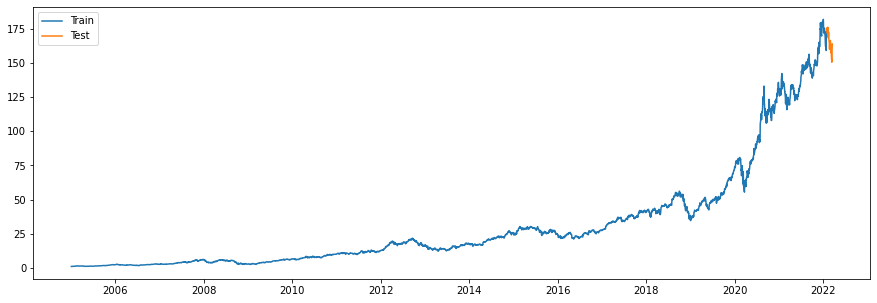

In [45]:
plt.figure(figsize = (15, 5))
plt.plot(X_train['close'], label = 'Train')
plt.plot(X_test['close'], label = 'Test')
plt.legend()

In [46]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4300, 7)
(4300,)
(33, 7)
(33,)


In [49]:
X_train.fillna(0, inplace = True)

C:\Users\workspace\Anaconda3\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [65]:
X_train.head(10)

,weekday,high,low,open,close,close_ratio,body
date,,,,,,,
2005-01-03,0,0.9967,0.9585,0.9930,0.9687,0.000000,-0.0243
2005-01-04,1,1.0023,0.9640,0.9760,0.9788,0.010426,0.0028
2005-01-05,2,0.9988,0.9788,0.9788,0.9875,0.008888,0.0087
2005-01-06,3,0.9935,0.9693,0.9921,0.9881,0.000608,-0.0040
2005-01-07,4,1.0658,0.9916,0.9958,1.0601,0.072867,0.0643
2005-01-10,0,1.0825,1.0392,1.0701,1.0559,-0.003962,-0.0142
2005-01-11,1,1.0589,0.9819,1.0447,0.9884,-0.063927,-0.0563
2005-01-12,2,1.0089,0.9690,1.0023,1.0023,0.014063,0.0000
2005-01-13,3,1.1394,1.0676,1.1310,1.0685,0.066048,-0.0625


In [61]:
#월~목까지의 데이터가 1set
def Scaler_to_np(df):
    df_list = []
    #weekday를 제외한 데이터만 입력
    df = np.array(df.iloc[:, 1:])
    for i in range(0, len(df)-9, 1):
        df_s = df[i:i+10]
        scaler = StandardScaler()
        df_scaler = scaler.fit_transform(df_s)
        df_list.append(df_scaler)
    return np.array(df_list)

In [62]:
X_train_array = Scaler_to_np(X_train)
X_test_array = Scaler_to_np(X_test)

In [63]:
print(X_train_array.shape)
print(X_test_array.shape)

(4291, 10, 6)
(24, 10, 6)


In [72]:
y_train_new = y_train[9:]
y_test_new = y_test[9:]

In [73]:
print(y_train_new.shape)
print(y_test_new.shape)

(4291,)
(24,)


In [74]:
def gen_lstm_compile(df):
    model = Sequential()
    model.add(LSTM(256, activation = 'relu', batch_input_shape = (None, df.shape[1], df.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [75]:
valid_scores = []
tscv = TimeSeriesSplit(n_splits=6)

In [76]:
for fold, (train_indicies, valid_indicies) in enumerate(tscv.split(X_train_array)):
    x_train_time, x_valid_time = X_train_array[train_indicies], X_train_array[valid_indicies]
    y_train_time, y_valid_time = y_train_new[train_indicies], y_train_new[valid_indicies]
    
    model = gen_lstm_compile(x_train_time)
    model.fit(x_train_time, y_train_time, epochs = 20, batch_size = 64)
    
    y_pred = model.predict(x_valid_time)
    y_pred = np.where(y_pred < 0.5, 0, 1)
    
    score = accuracy_score(y_valid_time, y_pred)
    print(f"fold{fold}, Score:{score}")
    valid_scores.append(score)    

Epoch 1/20
10/10 [==============================] - 2s 40ms/step - loss: 0.6688 - accuracy: 0.6052
Epoch 2/20
10/10 [==============================] - 0s 42ms/step - loss: 0.5864 - accuracy: 0.6917
Epoch 3/20
10/10 [==============================] - 0s 41ms/step - loss: 0.4155 - accuracy: 0.8124
Epoch 4/20
10/10 [==============================] - 0s 42ms/step - loss: 0.3467 - accuracy: 0.8434
Epoch 5/20
10/10 [==============================] - 0s 41ms/step - loss: 0.2713 - accuracy: 0.8842
Epoch 6/20
10/10 [==============================] - 0s 39ms/step - loss: 0.2470 - accuracy: 0.9070
Epoch 7/20
10/10 [==============================] - 0s 42ms/step - loss: 0.2247 - accuracy: 0.8907
Epoch 8/20
10/10 [==============================] - 0s 42ms/step - loss: 0.2235 - accuracy: 0.9119
Epoch 9/20
10/10 [==============================] - 0s 40ms/step - loss: 0.1808 - accuracy: 0.9282
Epoch 10/20
10/10 [==============================] - 0s 40ms/step - loss: 0.1812 - accuracy: 0.9217
Epoch 11/

39/39 [==============================] - 2s 42ms/step - loss: 0.0754 - accuracy: 0.9694
Epoch 16/20
39/39 [==============================] - 2s 40ms/step - loss: 0.0718 - accuracy: 0.9710
Epoch 17/20
39/39 [==============================] - 2s 40ms/step - loss: 0.0836 - accuracy: 0.9657
Epoch 18/20
39/39 [==============================] - 2s 41ms/step - loss: 0.0670 - accuracy: 0.9727
Epoch 19/20
39/39 [==============================] - 2s 41ms/step - loss: 0.0641 - accuracy: 0.9739
Epoch 20/20
39/39 [==============================] - 2s 40ms/step - loss: 0.0544 - accuracy: 0.9772
fold3, Score:0.9494290375203915
Epoch 1/20
48/48 [==============================] - 3s 41ms/step - loss: 0.4524 - accuracy: 0.7840
Epoch 2/20
48/48 [==============================] - 2s 40ms/step - loss: 0.2162 - accuracy: 0.9067
Epoch 3/20
48/48 [==============================] - 2s 41ms/step - loss: 0.1636 - accuracy: 0.9331
Epoch 4/20
48/48 [==============================] - 2s 40ms/step - loss: 0.1393 - a

In [77]:
#n_splites=3이 정확도가 더 높음
print(f"valid_scores:{valid_scores}")
cv_score = np.mean(valid_scores)
print(f"cv_score:{cv_score}")

valid_scores:[0.9526916802610114, 0.9412724306688418, 0.965742251223491, 0.9494290375203915, 0.9787928221859706, 0.9722675367047309]
cv_score:0.9600326264274063


In [78]:
pred = model.predict(X_test_array)
pred

array([[1.57883152e-01],
       [1.00000000e+00],
       [7.46693462e-03],
       [1.31336471e-08],
       [1.06123380e-05],
       [2.87094650e-07],
       [4.45842048e-08],
       [9.99977827e-01],
       [9.99959469e-01],
       [6.97161138e-01],
       [2.28816483e-04],
       [9.99999523e-01],
       [4.52035014e-03],
       [6.06328054e-09],
       [6.38318912e-12],
       [3.22003734e-06],
       [1.00000000e+00],
       [1.49294443e-09],
       [1.08225656e-07],
       [4.84904547e-07],
       [9.99993324e-01],
       [9.99999762e-01],
       [9.93712187e-01],
       [9.99999404e-01]], dtype=float32)

In [79]:
pred = np.where(pred<0.5,0,1)
pred

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1]])

In [80]:
print(f"accuracy = {accuracy_score(y_test_new, pred)}")

accuracy = 0.9583333333333334


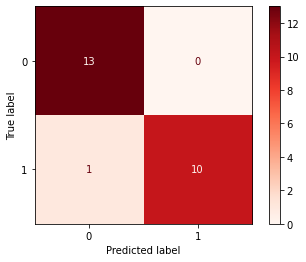

In [81]:
cm = confusion_matrix(y_test_new, pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap = plt.cm.Reds)

In [84]:
last_10days = Scaler_to_np(X_test[-10:])

In [87]:
pred_last_10 = model.predict(last_10days)

In [88]:
# 월요일 애플의 주가는 오르는 것으로 예측
print(np.where(pred_last_10 > 0.5, 1, 0))

[[1]]
